# 5. Application - Quantum Phase Estimation

Author : [Gwonhak Lee](https://github.com/snow0369) (gwonhak@gmail.com)

-----
 Qiskit에서 제공하는 양자알고리즘 솔루션 중 하나인 Quantum Phase Estimation을 활용해봅니다.

### 0. 필요한 요소 불러오기

In [1]:
import numpy as np

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.algorithms.phase_estimators import PhaseEstimation
from qiskit.providers.aer import AerProvider
from qiskit.tools.visualization import plot_histogram
from qiskit.utils import QuantumInstance

### 1. Quantum Phase Estimation

Quantum phase estimation은 Quantum Fourier Transform을 활용하여 Exponential speed-up을 달성하는
양자 알고리즘으로, 주어진 unitary matrix의 eigen phase를 계산합니다.
[(참고자료)](https://quantum-computing.ibm.com/composer/docs/iqx/guide/quantum-phase-estimation)

Phase estimation의 회로는 다음과 같습니다. 여기서 $|\psi\rangle$는 $U$의 eigenstate로써, 해당하는 eigenvalue는 $e^{i2\pi\theta}, \theta\in[0, 1)$입니다.

(모든 Unitary 행렬의 eigenvalue는 모두 크기가 1인 복소수입니다.)

![phase_estimation_diagram](https://github.com/snow0369/qiskit_tutorial_2021_summerschool/raw/master/figures/phase_estimation_diagram.png)

1. Hadamard 연산 후의 상태는 다음과 같습니다.

$$ |0\rangle ^{\otimes t} \otimes |\psi\rangle \rightarrow \frac{1}{\sqrt{2^t}}\sum_{k=0}^{2^t - 1}|k\rangle \otimes |\psi\rangle  $$

2. Controlled-$ U $ 를 위와 같이 적용하면, $k$의 binary 표현에서 most significant bit부터 차례대로
$U^{2^{t-1}}, U^{2^{t-2}}, \cdots, U^{2^0}$을 적용하기 때문에 다음과 같은 상태가 됩니다.

( note : $U^{k}|\psi\rangle = e^{i2k\pi\theta} $ )

$$ \frac{1}{\sqrt{2^t}}\sum_{k=0}^{2^t - 1}e^{i2k\pi\theta}|k\rangle \otimes |\psi\rangle $$

3. 다음으로, Inverse Quantum Fourier Transform을 취하면,

$$ \frac{1}{2^t}\sum_{x=0}^{2^t-1}\sum_{k=0}^{2^t-1}e^{-\frac{i2\pi k}{2^t}(x-2^t \theta)}|x\rangle \otimes |\psi\rangle $$

여기서 $|x\rangle$ 을 측정하면 $x\sim 2^t \theta$에서 가장 빈번하게 발생함을 알 수 있습니다.

Qiskit에서는 quantum phase estimation을 쉽게 구현할 수 있는 방법이 포함되어 있습니다. 이를 이용하는 실습을 진행합니다.

먼저, Eigen phase를 계산할 unitary 회로를 준비합니다.

depth =  3


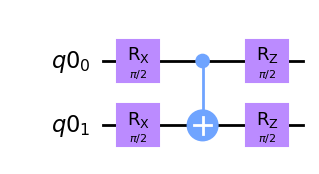

In [2]:
num_unitary_qubits = 2

unitary_qubit = QuantumRegister(num_unitary_qubits)
unitary_circuit = QuantumCircuit(unitary_qubit)
for i in range(num_unitary_qubits):
    unitary_circuit.rx(0.5*np.pi, i)
for i in range(num_unitary_qubits - 1):
    unitary_circuit.cx(i, i+1)
for i in range(num_unitary_qubits):
    unitary_circuit.rz(0.5*np.pi, i)

print("depth = ", unitary_circuit.depth())
unitary_circuit.draw('mpl')

다음으로, 초기 상태를 준비하기 위한 회로를 준비합니다. 이 때, 초기 상태는 관심있는 eigen state와 overlap이 많을 것으로 가정합니다.

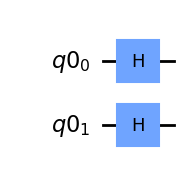

In [3]:
state_prep = QuantumCircuit(unitary_qubit)
state_prep.h(unitary_qubit)
state_prep.draw('mpl')

evaluation qubit의 갯수를 지정하고, Phase Estimation 회로를 구현합니다.

depth = 122


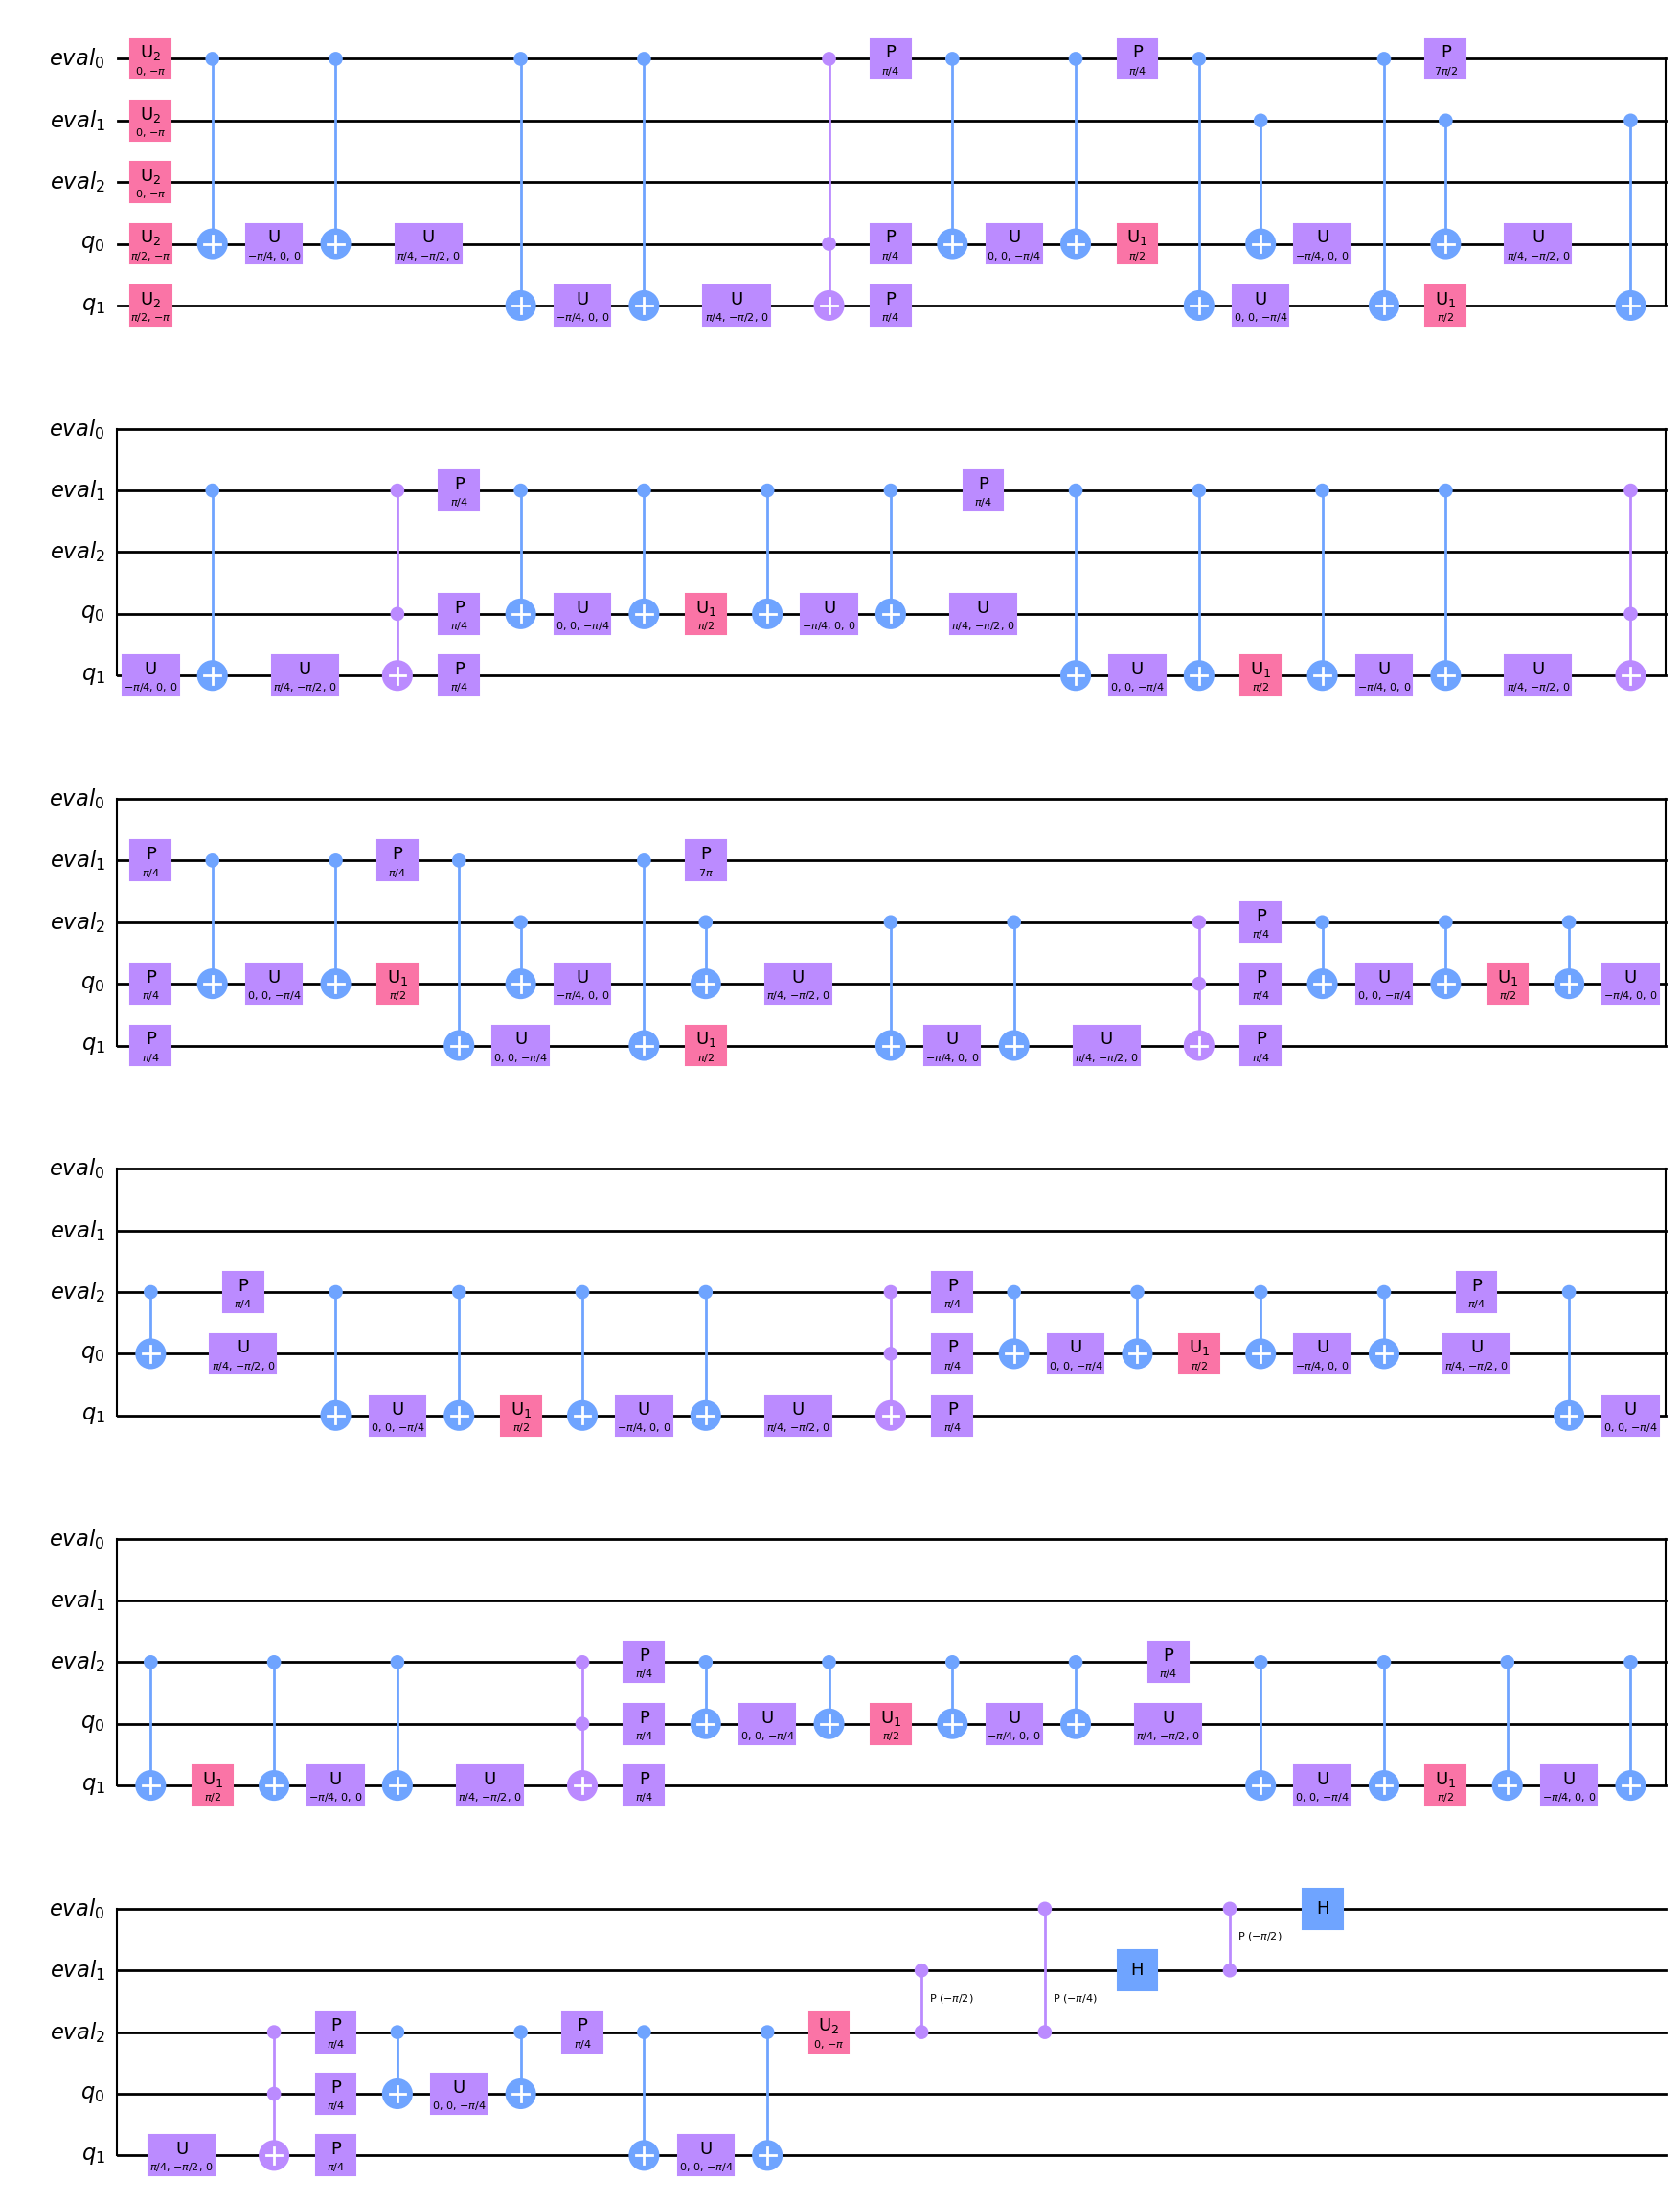

In [4]:
num_evaluation_qubits = 3

qasm_backend = AerProvider().get_backend("qasm_simulator")
qpe = PhaseEstimation(num_evaluation_qubits=num_evaluation_qubits,
                      quantum_instance=QuantumInstance(backend=qasm_backend,
                                                       shots=4096,
                                                       optimization_level=3))

ckt = qpe.construct_circuit(unitary_circuit, state_preparation=state_prep)
ckt = transpile(ckt, backend=qasm_backend)
print(f"depth = {ckt.depth()}")
ckt.draw('mpl')

QPE 알고리즘을 실행하고 결과를 출력합니다.

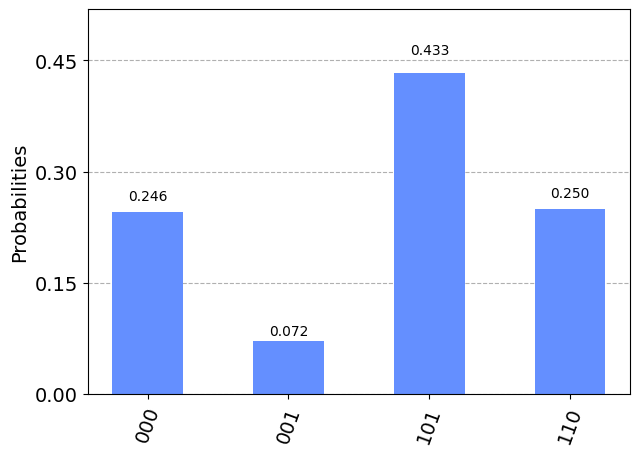

In [5]:
res = qpe.estimate(unitary_circuit, state_prep)
plot_histogram(res.phases)

In [6]:
phase_list = sorted(res.phases.keys(), key=lambda x: res.phases[x], reverse=True)
for p in sorted(phase_list):
    bin_p = int(p, 2) / 2**num_evaluation_qubits
    print(f"phase[rad] : {2*bin_p*np.pi}, occurence : {res.phases[p]}")

phase[rad] : 0.0, occurence : 0.24560546875
phase[rad] : 0.7853981633974483, occurence : 0.072021484375
phase[rad] : 3.9269908169872414, occurence : 0.4326171875
phase[rad] : 4.71238898038469, occurence : 0.249755859375


실험으로 얻은 값을 비교하기 위해 unitary simulator를 이용하여 unitary 회로의 행렬 형태를 얻은 뒤, eigen problem의 해를 구한다.

In [7]:
unitary_simulator = AerProvider().get_backend('unitary_simulator')
job_unitary = unitary_simulator.run(unitary_circuit)
mat = job_unitary.result().get_unitary()
print(mat)

[[ 0. -0.5j -0.5+0.j  -0.5+0.j   0. +0.5j]
 [-0.5+0.j   0. -0.5j  0. -0.5j  0.5+0.j ]
 [ 0. -0.5j -0.5+0.j   0.5+0.j   0. -0.5j]
 [ 0.5+0.j   0. +0.5j  0. -0.5j  0.5+0.j ]]


In [8]:
eigval, eigvec = np.linalg.eig(mat)
assert all(np.isclose(np.abs(eigval), 1.0))
eigph = np.angle(eigval)
for i, p in enumerate(eigph):
    if p < 0:
        eigph[i] = 2*np.pi + p
print("eig phase = ", sorted(eigph))
for i, v in enumerate(eigvec):
    print(f"eigvec {i} = {v/np.linalg.norm(v, ord=2)}")

eig phase =  [0.7853981633974485, 3.9269908169872414, 4.71238898038469, 6.283185307179586]
eigvec 0 = [ 6.53281482e-01+1.50455499e-17j -5.00000000e-01+6.49835883e-16j
  2.44494543e-16+5.00000000e-01j -2.70598050e-01+5.69363576e-17j]
eigvec 1 = [ 6.53281482e-01+0.00000000e+00j  5.00000000e-01+0.00000000e+00j
 -1.94159624e-16-5.00000000e-01j -2.70598050e-01-5.05517184e-17j]
eigvec 2 = [ 2.70598050e-01-1.94796269e-16j -1.37484272e-16-5.00000000e-01j
  5.00000000e-01+0.00000000e+00j  6.53281482e-01+0.00000000e+00j]
eigvec 3 = [-2.70598050e-01-1.57807601e-16j -1.46825868e-16-5.00000000e-01j
  5.00000000e-01-6.09556052e-16j -6.53281482e-01+6.41820141e-17j]


### (추가) Transpile optimization
fake rome backend를 활용하여 transpile optimization 과정의 차이를 살펴보겠습니다.

In [9]:
from qiskit.test.mock import FakeRome
fake_rome = FakeRome()

# 측정게이트 추가
eval_qubits = ckt.qregs[0]
creg = ClassicalRegister(len(eval_qubits))
ckt.add_register(creg)
ckt.measure(eval_qubits, creg)

In [10]:
ckt_lv0 = transpile(ckt, backend=fake_rome, optimization_level=0)
ckt_lv1 = transpile(ckt, backend=fake_rome, optimization_level=1)
ckt_lv2 = transpile(ckt, backend=fake_rome, optimization_level=2)
ckt_lv3 = transpile(ckt, backend=fake_rome, optimization_level=3)

In [11]:
for i, ckt_opt in enumerate([ckt_lv0, ckt_lv1, ckt_lv2, ckt_lv3]):
    cnot_count = ckt_opt.count_ops()['cx'] if 'cx' in ckt_opt.count_ops() else 0
    print(f"opt_level={i}, depth={ckt_opt.depth()}, cnot_count={cnot_count}")

opt_level=0, depth=525, cnot_count=221
opt_level=1, depth=332, cnot_count=202
opt_level=2, depth=321, cnot_count=194
opt_level=3, depth=314, cnot_count=138
